In [1]:
import os

import numpy as np
from numpy.linalg import norm
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
import xgboost as xgb

from utils import get_hash
from utils import Featurizer
from utils import plot_confusion_matrix

In [2]:
pd.set_option('display.max_colwidth', 1000)

In [3]:
# Create a featurizer object that converts a phrase into embedding vector
emb_file = os.path.join("munge", "GoogleNews-vectors-negative300.bin")
featurizer = Featurizer(emb_file)

Loading word vectors...
Done! Using 3000000 word vectors from pre-trained word2vec.


In [4]:
train = pd.read_csv(os.path.join("munge", "train.csv"))
dev = pd.read_csv(os.path.join("munge", "dev.csv"))
test = pd.read_csv(os.path.join("munge", "test.csv"))

In [5]:
landmarks = pd.read_csv(os.path.join("munge", "landmarks.txt"), sep="\t")
# Convert embeddings from string to list of floats
landmarks['embedding'] = landmarks['embedding'].apply(lambda x : list(map(float, x.split(','))))

In [7]:
def get_features(landmarks, obs):
        
    # Get observation values
    pd_hash = get_hash(obs['problem_description'])
    qu_hash = get_hash(obs['question'])
    emb = featurizer.doc2vec(obs['answer'])
        
    # Landmark of different question will get zero similarity (default)
    qu_land = landmarks.copy()
    qu_land['similarity'] = 0
    
    # Compute similarity when embedding is not zero and landmark from same question
    if norm(emb)!=0:
        # Get index of landmarks with same problem  and question 
        idx = qu_land[(qu_land['pd_hash']==pd_hash) & (qu_land['qu_hash']==qu_hash)].index
        # Compute the similarity with these landmarks
        qu_land.loc[idx, 'similarity'] = qu_land.loc[idx, 'embedding'].apply(lambda x : featurizer.cossim_from_emb(emb, np.array(x)))
        
    # Features will be all similarity measures to landmarks
    features = np.array(qu_land['similarity'])
    
    # Add feature to indicate wether or not observation embedding was zero
    if norm(emb)==0:
        features = np.append(1, features)
    else:
        features = np.append(0, features)
        
    # Add features to indicate similarity to question and to problem description
    if norm(emb)==0:
        sim_to_qu = 0
        sim_to_pd = 0
    else:
        sim_to_qu = featurizer.cossim_from_phrase(obs['answer'], obs['question'])
        sim_to_pd = featurizer.cossim_from_phrase(obs['answer'], obs['problem_description'])
    features = np.append(sim_to_qu, features)
    features = np.append(sim_to_pd, features)

    return features

In [8]:
def kernel_matrix(data, landmarks):
    
    features = np.array(list(data.apply(lambda x : get_features(landmarks, x), axis=1)))
    return(features)

In [9]:
X_train = kernel_matrix(train, landmarks)
X_dev = kernel_matrix(dev, landmarks)
X_test = kernel_matrix(test, landmarks)

y_train = np.array(train['label'])
y_dev = np.array(dev['label'])
y_test = np.array(test['label'])

In [10]:
model = LogisticRegression(random_state=22, solver='lbfgs', max_iter=1000, C=100,
                           multi_class='multinomial').fit(X_train, y_train)

In [69]:
from sklearn.model_selection import GridSearchCV
import time

print("Fitting the classifier to the training set...")
t0 = time.time()

param_grid = {'C': [1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 1e2, 1e3, 1e4]}
clf = GridSearchCV(LogisticRegression(random_state=22, solver='lbfgs', max_iter=1000, multi_class='multinomial'),
                   param_grid,
                   cv=20,
                   n_jobs=-1)

clf = clf.fit(X_train, y_train)
model = clf.best_estimator_

print("done in %0.3fs" % (time.time() - t0))
print("Best estimator found by grid search:")
print(model)

Fitting the classifier to the training set...


/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


done in 60.220s
Best estimator found by grid search:
LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=1000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=22, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)


# Performance Evaluation

In [67]:
def get_prediction(X, thresh):
    pred = model.predict_proba(X)
    pred = [[(class_id, proba) for (class_id, proba) in enumerate(p) if proba == np.max(p)] for p in pred]
    pred = [p[0][0] if p[0][1]>thresh else 99 for p in pred]
    return np.array(pred)

y_hat_test = get_prediction(X_test, 0.7)

print('response:', 1-np.mean(y_hat_test==99))

response: 0.5833333333333333


In [72]:
def get_performance(predictions, labels, thresh):
    
    """Measure the accuracy and the unknown rate depending on the threshold
    Args:
        predictions: list of tuples (prediction, dist)
        label: list of labels
        thresh: distance threshold above which the prediction becomes unknown
        
    Returns:
        accuracy: proportion of correct predictions when not unkown
        unknown_rate: proportion of predictions that are unknown    
    """
    
    # Measure the rate of known predictions
    response_rate = 1 - np.mean(predictions==99)
    
    # Get the indices of predictions to keep
    known_idx = [i for i in range(len(predictions)) if predictions[i]!=99]
    
    # get predictions that are not unknown
    mini_predictions = np.array([predictions[idx] for idx in known_idx])
    mini_labels = np.array([labels[idx] for idx in known_idx])
    
    # Measure the accuracy
    accuracy = np.mean(mini_predictions == mini_labels)
    
    # Ouput dictionary
    output = {"accuracy": accuracy,
              "response_rate": response_rate}
    
    return output


/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


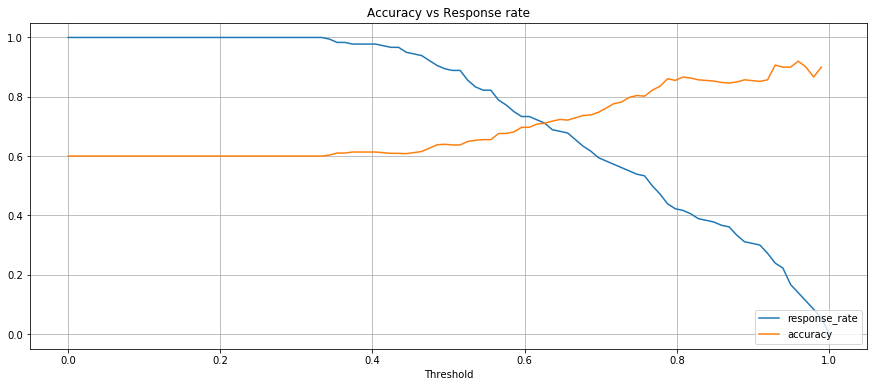

In [74]:
# Plot the performance against the threshold
accuracy = []
response_rate = []
threshold = np.linspace(start = 0, stop = 1, num=100)

for thresh in threshold:
    predictions = get_prediction(X_dev, thresh)
    labels = y_dev
    perf = get_performance(predictions, labels, thresh)
    accuracy.append(perf["accuracy"])
    response_rate.append(perf["response_rate"])
    
plt.figure(figsize=(15,6))
plt.plot(threshold, response_rate)
plt.plot(threshold, accuracy)
plt.legend(['response_rate', 'accuracy'], loc='lower right')
plt.title('Accuracy vs Response rate')
plt.xlabel('Threshold')
plt.grid(True)
plt.show()

In [75]:
model.predict(X_dev)

array([1, 0, 0, 3, 0, 3, 0, 0, 2, 1, 0, 0, 3, 3, 3, 3, 3, 0, 0, 3, 3, 3,
       2, 0, 3, 0, 3, 0, 1, 0, 1, 0, 0, 1, 1, 1, 2, 1, 3, 0, 1, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 2, 3, 3, 3, 0, 1, 1, 1, 0, 0, 0, 0, 3, 0, 3, 2,
       3, 1, 0, 0, 1, 2, 1, 0, 0, 1, 3, 0, 0, 3, 0, 0, 3, 0, 3, 0, 1, 0,
       1, 0, 2, 2, 1, 3, 0, 0, 1, 3, 1, 0, 3, 2, 3, 0, 3, 2, 3, 0, 1, 0,
       3, 0, 1, 0, 1, 0, 0, 0, 3, 0, 0, 0, 0, 0, 3, 1, 0, 3, 3, 1, 3, 0,
       0, 1, 3, 3, 1, 2, 3, 2, 0, 0, 0, 0, 0, 3, 1, 2, 0, 0, 0, 1, 0, 1,
       2, 0, 3, 1, 1, 0, 3, 3, 0, 0, 0, 0, 3, 3, 1, 3, 2, 3, 1, 3, 2, 0,
       1, 0, 3, 0])

In [92]:
labels = np.array(dev['label'])
labels

array([1, 2, 0, 0, 0, 3, 0, 1, 0, 1, 0, 0, 0, 3, 3, 0, 3, 0, 1, 3, 0, 0,
       0, 0, 3, 0, 1, 1, 1, 1, 3, 0, 0, 3, 1, 3, 1, 0, 2, 0, 1, 0, 0, 0,
       3, 3, 0, 0, 0, 0, 2, 1, 3, 3, 0, 0, 3, 0, 0, 0, 0, 0, 0, 3, 2, 2,
       1, 1, 0, 1, 3, 2, 0, 0, 1, 1, 3, 1, 0, 3, 3, 0, 2, 0, 3, 0, 1, 0,
       1, 0, 3, 1, 1, 3, 2, 0, 3, 0, 1, 1, 1, 0, 3, 3, 3, 0, 3, 0, 3, 0,
       3, 3, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 3, 2, 3, 1, 1, 0,
       0, 3, 2, 3, 1, 0, 3, 0, 0, 1, 0, 1, 1, 3, 1, 2, 0, 0, 1, 1, 0, 1,
       2, 0, 3, 1, 1, 0, 3, 1, 2, 0, 0, 0, 3, 2, 3, 2, 2, 0, 1, 3, 2, 0,
       1, 0, 3, 0])

## Accuracy

In [79]:
# Final accuracy
y_hat_train = model.predict(X_train)
acc = np.round(np.mean(y_train == y_hat_train),2)
print("Performance on training set")
print('Accuracy: {}'.format(acc))

Performance on training set
Accuracy: 0.96


In [80]:
# Final accuracy
y_hat_dev = model.predict(X_dev)
acc = np.round(np.mean(y_dev == y_hat_dev),2)
print("Performance on dev set")
print('Accuracy: {}'.format(acc))

Performance on dev set
Accuracy: 0.6


In [81]:
# Final accuracy
y_hat_test = model.predict(X_test)
acc = np.round(np.mean(y_test == y_hat_test),2)
print("Performance on test set")
print('Accuracy: {}'.format(acc))

Performance on test set
Accuracy: 0.56


## Confusion Matrix

In [82]:
# Get class names for display
class_dict = {0: 'correct', 1:'correct_but_incomplete', 2:'contradictory', 3:'incorrect'}
class_ids = list(np.unique(y_test))
class_names = [class_dict[cid] for cid in class_ids]

Confusion matrix, without normalization
[[53  9  3  9]
 [13 17  0  8]
 [ 5  4  4  4]
 [ 9 10  5 27]]


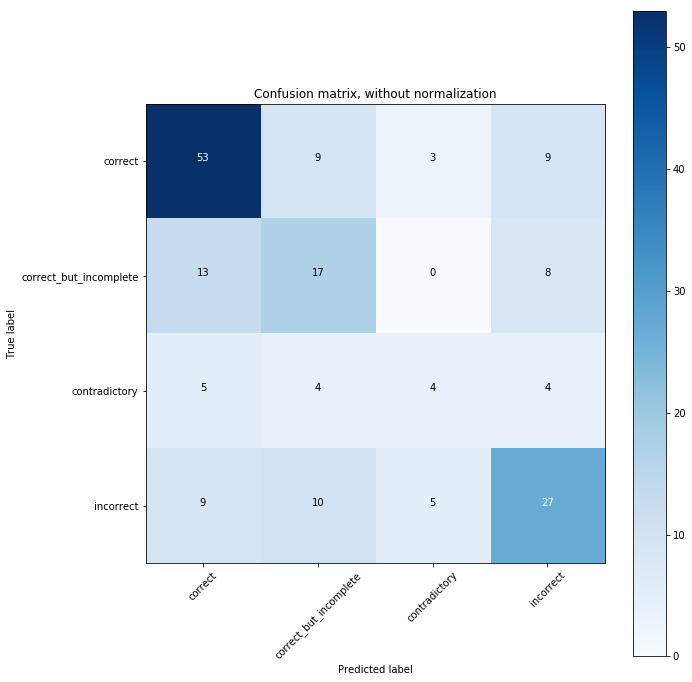

In [83]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_hat_test)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(10,10))
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization',
                      cmap=plt.cm.Blues)

## Classification Report

In [42]:
# Compute classification report
clf_report = classification_report(y_test, y_hat_test, target_names=class_names)
print(clf_report)

                        precision    recall  f1-score   support

               correct       0.66      0.72      0.69        74
correct_but_incomplete       0.42      0.45      0.44        38
         contradictory       0.33      0.24      0.28        17
             incorrect       0.56      0.53      0.55        51

             micro avg       0.56      0.56      0.56       180
             macro avg       0.50      0.48      0.49       180
          weighted avg       0.55      0.56      0.56       180



# Error Analysis

In [30]:
dev['pred'] = y_hat_dev

In [31]:
dev[(dev['label']==1) & (dev['pred']==0)]

,instance_id,student_id,task_id,problem_description,question,answer,reference_answers,label,pred
7,246,DTSU033,LP03_PR12.push.accel.bMLK.sh,"While speeding up, a large truck pushes a small compact car.",How does Newton's third law apply to this situation?,The truck and car exert equal amount of force on each other.,"1: The force from the car on the truck and the force from the truck on the car are a Third Law pair. Thus, the forces are equal in magnitude and opposite in direction. 2: The forces exerted by the truck and car are equal and opposite. 3: The forces from the truck and car are equal and opposite. 4: The force from the truck and the force from the car are equal and opposite. 5: The force from the truck and the force from the car are form action reaction pair.",1,0
18,806,DTSU024,LP03_PR12.push.accel.bMLK,"While speeding up, a large truck pushes a small compact car.",How does Newton's third law apply to this situation?,"The large truck exerts a force on the car, and the car will exert the same force on the truck","1: The force from the car on the truck and the force from the truck on the car are a Third Law pair. Thus, the forces are equal in magnitude and opposite in direction. 2: The forces exerted by the truck and car are equal and opposite. 3: The forces from the truck and car are equal and opposite. 4: The force from the truck and the force from the car are equal and opposite. 5: The force from the truck and the force from the car form action reaction pair.",1,0
26,171,DTSU013,FM_LV04_PR05,Two hockey players pass a puck between them on an ice rink. Assume that the ice is very smooth so that there is no friction.,"Based on Newton's first law, what can you say about the trajectory and speed of the puck?",It will move in a straight line and stay on the ice.,1: The puck will move in a straight line with a constant speed.,1,0
27,883,DTSU008,FM_LV03_PR07,"A mover pushes a desk with a horizontal force such that the desk moves with constant velocity v0 across a carpeted floor. Suddenly, the mover doubles his force.",Which other Newton law is relevant now given that we established that there is a non-zero net force on the desk after the mover doubles his force?,Newton's second law is relevant,"1: When the mover doubles his force, the push is greater than friction resulting in a non-zero net force acting on the desk and so Newton's second law can be applied. 2: Newton's second law applies as there is a non-zero net force. 3: Newton's 2nd law applies as a non-zero net force acts on the desk",1,0
29,709,DTSU027,LP03_PR12.push.accel.bMLK,"While speeding up, a large truck pushes a small compact car.",How does Newton's third law apply to this situation?,The force of the truck is equal to the force of the car.,"1: The force from the car on the truck and the force from the truck on the car are a Third Law pair. Thus, the forces are equal in magnitude and opposite in direction. 2: The forces exerted by the truck and car are equal and opposite. 3: The forces from the truck and car are equal and opposite. 4: The force from the truck and the force from the car are equal and opposite. 5: The force from the truck and the force from the car form action reaction pair.",1,0
51,734,DTSU024,FM_LVxx_PR01,A rocket pushes a meteor with constant force. Assume that the meteor is initially at rest and is far enough away from the sun and the planets to neglect gravity.,"Given the non-zero net force acting on the meteor, what does Newton's second law say about the acceleration of the meteor?","Since there is a non-zero net force, the acceleration of the meteor will also be non-zero","1: Because there is a net force acting on the meteor, which is the same as the push from the rocket as no other forces are acting on it, the meteor will move with a non-zero acceleration in the direction of the net force. 2: The push from the rocket makes the meteor move with a non-zero acceleration, according to Newton's second law. 3: According to Newton's second law,